# Through Earnings WS Estimize Delta Event Study

In this notebook we explore the relationship between the Wall Street/Estimize EPS delta (just prior to the earnings announcement) and the cumulative residual returns starting from the close before the earnings announcement and in the days following.

**Conclusions:**

* There is a positive cumulative residual return when the EPS delta is positive and vice versa
* Positive EPS deltas tend to produce a larger positive return than negative ones
* Sector analysis showed that Consumer Discretionary, Healthcare and Materials produced the strongest alpha
* Market Cap analysis showed that Micro and Small Cap stocks produced the strongest alpha

## Data and Methodology

**Datasources:**

* EPS Consensus values (Estimize consensuses.csv)
* Asset historical prices (Zipline.io/Quandl prices dataset)
* SPY historical prices (Yahoo Finance)

Our first step is to generate the Wall Street and Estimize Weighted EPS deltas for each release:

$$EPSDelta = \frac{EPS_{wallstreet} - EPS_{estimize}}{STDEV_{estimize} + 0.01}$$

Where $STDEV_{estimize}$ is the standard deviation of the release's estimize consensus.

After calculating the EPS deltas for all reported releases, we group them by quantile, with 1 being the lowest and 5 being the highest. This set of data represents the events we will plug into the event study.

The next step is to get the residual returns for each stock following an event. We calculate the residual returns using the CAPM with S&P500 index as the market portfolio:

$$E(R_{i,t})=b_0 + b_1 \cdot E(R_{M,t})$$

,

$$ResidualReturn_{i,t}=R_{i,t} - E(R_{i,t})$$

Finally, we take the cumulative residual returns over the days in the event study grouped by the EPS delta quantile.

**Disclaimer:**

This event study was prepared in a fashion similar to other event studies and research done in this field. Since the decile calculations are done ex-post, it should be noted that any trading strategy using this factor should calculate the eps delta deciles in a rolling fashion.

In [1]:
# Imports

from datetime import timedelta
from IPython.display import display, HTML, Markdown
import logging.config
import math
import os
import sys

from injector import Injector
import matplotlib.cm as cmx
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import stats

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

import estimize.config as cfg
from estimize.logging import configure_logging
from estimize.di.default_module import DefaultModule
from estimize.services import (
    AssetService, AssetInfoService, CalendarService, EstimatesService, 
    EstimizeConsensusService, EventStudyService, MarketCapService, ReleasesService
)
from estimize.pandas import dfutils

configure_logging('ERROR')

injector = Injector([DefaultModule])
asset_service = injector.get(AssetService)
calendar_service = injector.get(CalendarService)
estimates_service = injector.get(EstimatesService)
releases_service = injector.get(ReleasesService)
estimize_consensus_service = injector.get(EstimizeConsensusService)


In [2]:
def plot_results(df):
    """
    Plots cumulative residual returns based on decile.
    
    Parameters
    ----------
    df : pd.DataFrame
    """
    df = df.reset_index()
    df.set_index('event_time', inplace=True)
    
    plt.figure(figsize=(16, 10))
    
    quantiles = list(df['quantile'].astype('int').unique())
    quantiles.reverse()
    
    cm = plt.get_cmap('jet_r') 
    c_norm  = colors.Normalize(vmin=quantiles[-1], vmax=quantiles[0])
    scalar_map = cmx.ScalarMappable(norm=c_norm, cmap=cm)
    
    for quantile in quantiles:
        if quantile == quantiles[0] or quantile == quantiles[-1]:
            linewidth = 2.0
        else:
            linewidth = 1.0
            
        color = scalar_map.to_rgba(quantile)
            
        ddf = df.loc[df['quantile'] == quantile, 'cumulative_residual_return']
        ddf -= ddf.iloc[0]
        ddf *= 100.0
        ddf.plot(xticks=range(0, 21), label=quantile, linewidth=linewidth, color=color)
        
    plt.plot([0 for _ in range(0, 21)], 'r--')
    
    plt.ylabel("% Cumulative Residual Return")
    plt.xlabel("Event Time")
    plt.gca().grid(True)
    plt.legend(title='Quantile', loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.show()

def display_table(df):
    df = df.reset_index()

    df = pd.pivot_table(df, values='cumulative_residual_return', index='quantile', columns=['event_time'])
    df *= 100
    df = df.subtract(df[0], axis='index')
    df = df[[1, 2, 3, 4, 5, 10, 15, 20]]
    df = df.applymap("{0:.2f}%".format)
    display(df)

def display_results(es, title=None):
    df, events = es
    num_events = df.loc[df.index.get_level_values('event_time') == 0, 'count'].sum()
    
    if title is not None:
        display(Markdown('### {}'.format(title)))
        
    print('Num Events: {:,}'.format(num_events))
    
    plot_results(df)
    display_table(df)

def filter(df, column, value):
    return df[dfutils.column_values(df, column) == value]

def shift_date_fn(days):
    if days > 0:
        index = -1
    else:
        index = 0
    
    def shift_date(date):
        if days != 0:
            return calendar_service.get_n_trading_days_from(days, date)[index]
        else:
            return date
    
    return shift_date  

def fix_index(df):
    def fix_row_index(row):
        index = row[0]
        cols = row[1]
        date = index[0]
        asset = index[1]

        if cols['bmo']:
            date = date - timedelta(days=1)

        date = calendar_service.get_valid_trading_end_date(date)

        return date, asset

    df.index = pd.MultiIndex.from_tuples(list(map(fix_row_index, df.iterrows())))
    df.index.names = ['as_of_date', 'asset']

def get_eps_deltas(start_date, end_date):
    df = estimize_consensus_service.get_final_consensuses(start_date, end_date)
    df['eps_delta'] = (df['wallstreet.eps'] - df['estimize.eps.weighted']) / (df['estimize.eps.sd'] + 0.01)
    df = df[['bmo', 'eps_delta']].copy()
    df.dropna(inplace=True)
    fix_index(df)
    df.drop(['bmo'], axis=1, inplace=True)
    
    return df

def get_events(start_date, end_date):
    df = get_eps_deltas(start_date, end_date)
    
    # Filter on universe
    udf = asset_service.get_universe(start_date, end_date)
    df = df.join(udf, how='inner')
    
    # Add quantile
    df['quantile'] = pd.qcut(df['eps_delta'].values, 5, labels=False) + 1
    df.drop(['eps_delta'], axis=1, inplace=True)
    
    return df

def run_event_study(start_date, end_date, join_fn=None):
    event_study_service = injector.get(EventStudyService)
    events = get_events(start_date, end_date)
    
    if join_fn is not None:
        events = join_fn(start_date, end_date, events)
    
    df = event_study_service.run_event_study(
        events=events,
        on='close',
        days_before=0,
        days_after=20
    )
    
    return (df, events)

def join_sectors(start_date, end_date, events):
    asset_info_service = injector.get(AssetInfoService)
    df = asset_info_service.get_asset_info()['sector']

    events.reset_index(inplace=True)
    events.set_index('asset', inplace=True)
    events = events.join(df, how='inner')

    events.reset_index(inplace=True)
    events.set_index(['as_of_date', 'asset'], inplace=True)

    return events

def join_market_caps(start_date, end_date, events):
    market_cap_service = injector.get(MarketCapService)
    assets = dfutils.unique_assets(events)
    df = market_cap_service.get_market_caps(start_date, end_date, assets)['market_cap_type']
    df.rename({'market_cap_type': 'market_cap'}, inplace=True)

    events = events.join(df, how='inner')

    return events


## EPS Deltas

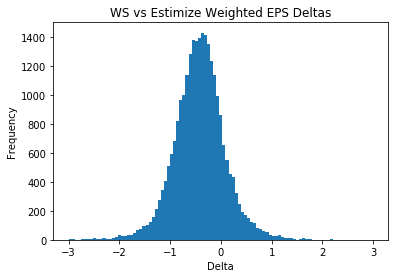

In [3]:
edf = get_eps_deltas(cfg.DEFAULT_START_DATE, cfg.DEFAULT_END_DATE)['eps_delta']

bins = np.linspace(-3, 3, 100)
plt.hist(edf, bins)
plt.title("WS vs Estimize Weighted EPS Deltas")
plt.xlabel("Delta")
plt.ylabel("Frequency")
plt.show()


In [4]:
# Run all-time event study

es_alltime = run_event_study(cfg.DEFAULT_START_DATE, cfg.DEFAULT_END_DATE)


### All Stocks (All-time)

Num Events: 24,327


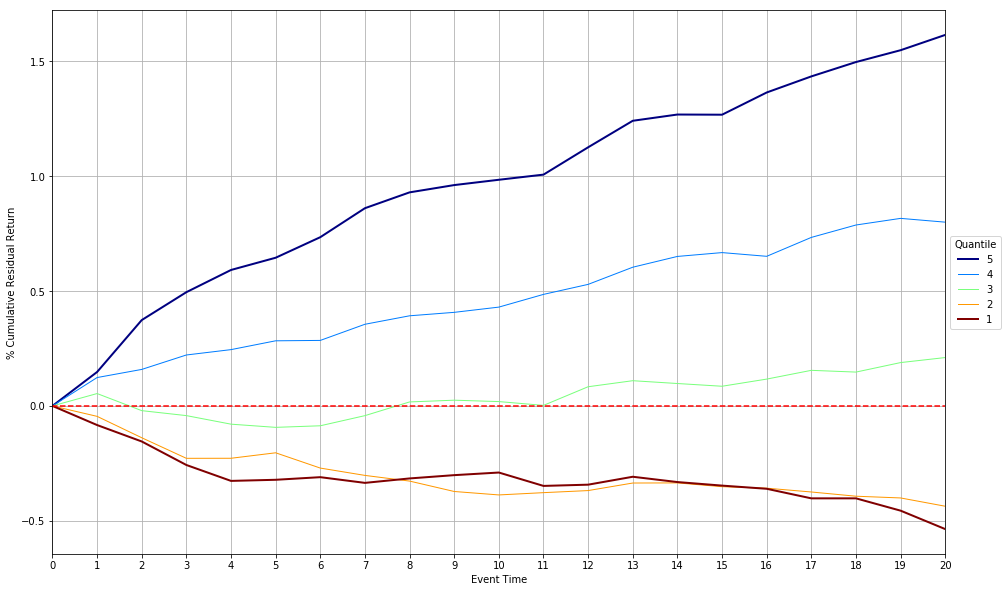

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.08%,-0.15%,-0.26%,-0.33%,-0.32%,-0.29%,-0.35%,-0.54%
2.0,-0.05%,-0.14%,-0.23%,-0.23%,-0.20%,-0.39%,-0.35%,-0.44%
3.0,0.05%,-0.02%,-0.04%,-0.08%,-0.09%,0.02%,0.09%,0.21%
4.0,0.12%,0.16%,0.22%,0.25%,0.28%,0.43%,0.67%,0.80%
5.0,0.15%,0.37%,0.50%,0.59%,0.64%,0.98%,1.27%,1.61%


In [6]:
display_results(es_alltime, 'All Stocks (All-time)')

In [7]:
# Run 2018 event study

start_date = '2018-01-01'
end_date = '2019-01-01'

es2018 = run_event_study(start_date, end_date)

### All Stocks (up to Q1 2018)

Num Events: 1,436


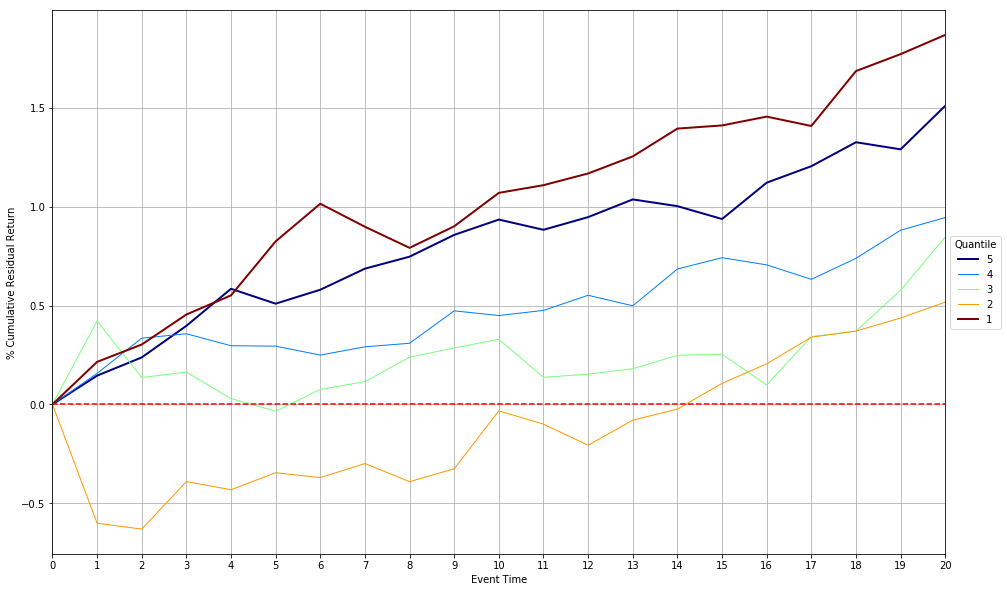

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.21%,0.30%,0.45%,0.55%,0.82%,1.07%,1.41%,1.87%
2.0,-0.60%,-0.63%,-0.39%,-0.43%,-0.35%,-0.03%,0.11%,0.52%
3.0,0.42%,0.14%,0.16%,0.03%,-0.03%,0.33%,0.25%,0.85%
4.0,0.16%,0.33%,0.36%,0.30%,0.29%,0.45%,0.74%,0.94%
5.0,0.15%,0.24%,0.40%,0.58%,0.51%,0.93%,0.94%,1.51%


In [9]:
display_results(es2018, 'All Stocks (up to Q1 2018)')

In [10]:
# Run 2017 event study

start_date = '2017-01-01'
end_date = '2018-01-01'

es2017 = run_event_study(start_date, end_date)

### All Stocks (2017)

Num Events: 5,936


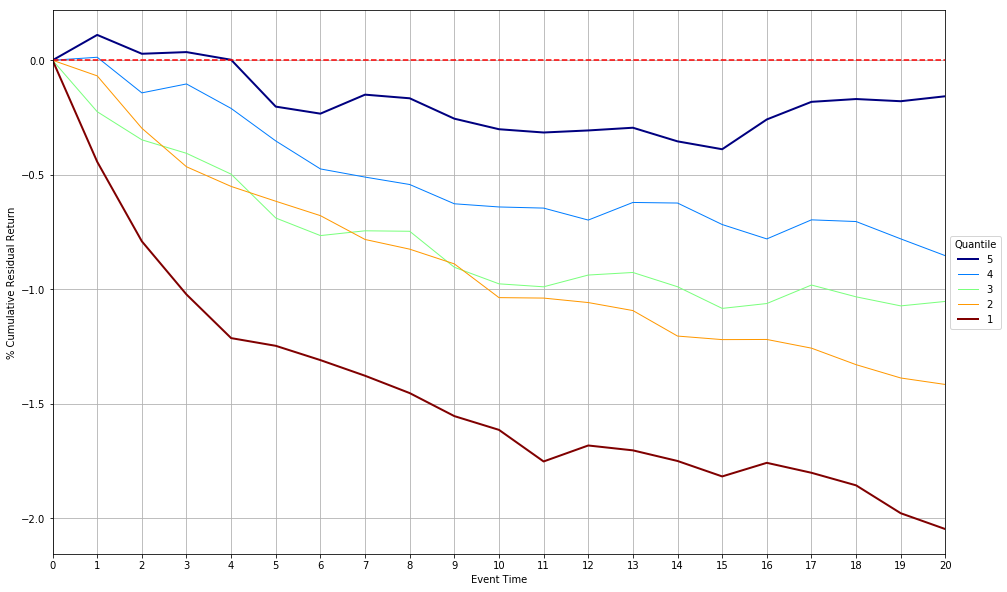

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.44%,-0.79%,-1.02%,-1.21%,-1.25%,-1.61%,-1.82%,-2.05%
2.0,-0.07%,-0.30%,-0.47%,-0.55%,-0.62%,-1.04%,-1.22%,-1.42%
3.0,-0.22%,-0.35%,-0.41%,-0.50%,-0.69%,-0.98%,-1.08%,-1.05%
4.0,0.01%,-0.14%,-0.10%,-0.21%,-0.35%,-0.64%,-0.72%,-0.85%
5.0,0.11%,0.03%,0.04%,0.00%,-0.20%,-0.30%,-0.39%,-0.16%


In [11]:
display_results(es2017, 'All Stocks (2017)')

In [12]:
# Run 2016 event study

start_date = '2016-01-01'
end_date = '2017-01-01'

es2016 = run_event_study(start_date, end_date)

### All Stocks (2016)

Num Events: 5,781


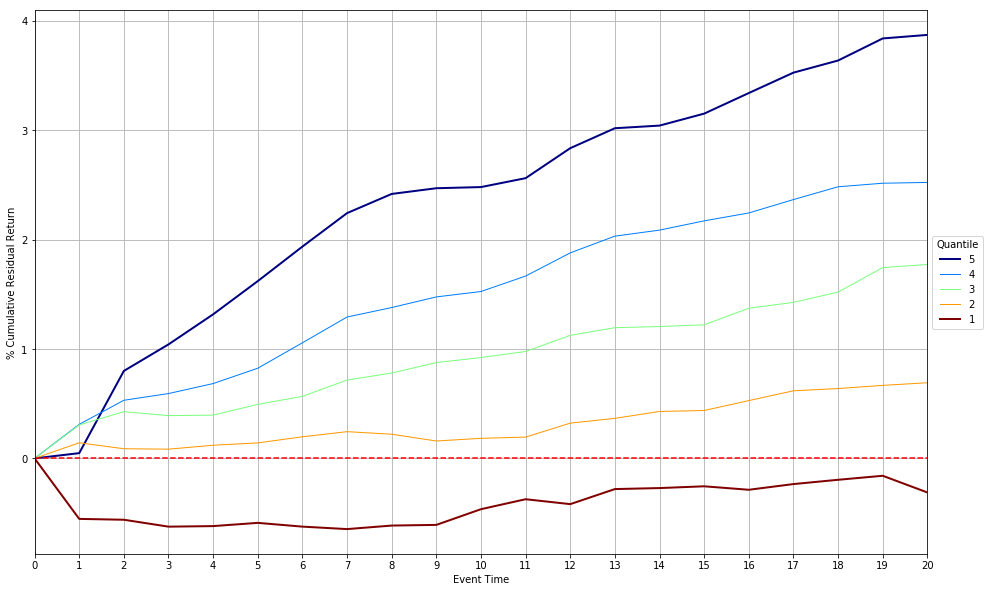

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.55%,-0.56%,-0.62%,-0.62%,-0.59%,-0.46%,-0.26%,-0.31%
2.0,0.14%,0.09%,0.08%,0.12%,0.14%,0.18%,0.44%,0.69%
3.0,0.31%,0.43%,0.39%,0.40%,0.49%,0.92%,1.22%,1.77%
4.0,0.31%,0.53%,0.59%,0.68%,0.82%,1.53%,2.17%,2.52%
5.0,0.05%,0.80%,1.04%,1.32%,1.62%,2.48%,3.15%,3.87%


In [13]:
display_results(es2016, 'All Stocks (2016)')

In [14]:
# Run 2015 event study

start_date = '2015-01-01'
end_date = '2016-01-01'

es2015 = run_event_study(start_date, end_date)

### All Stocks (2015)

Num Events: 4,722


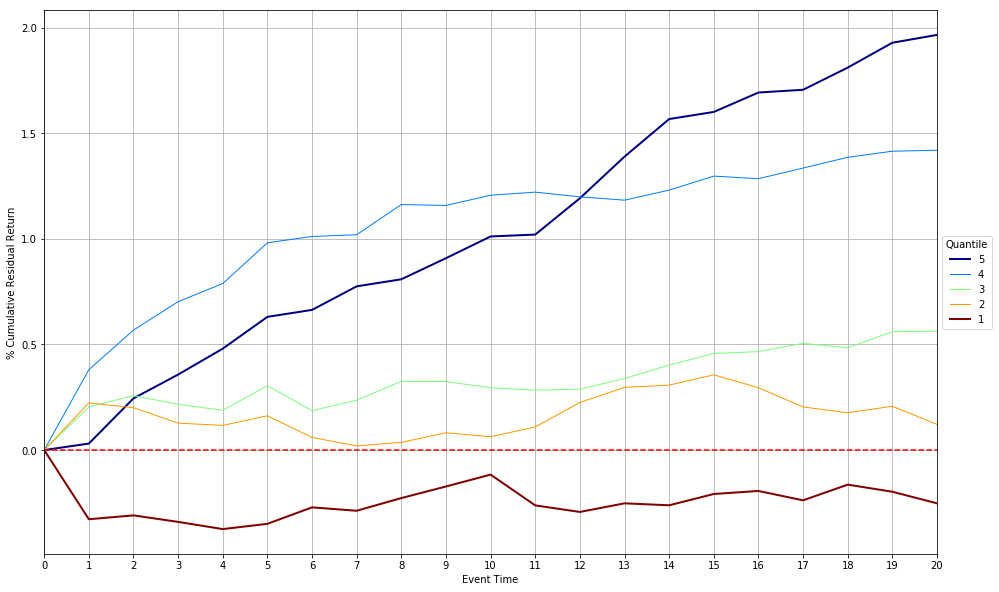

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.33%,-0.31%,-0.34%,-0.37%,-0.35%,-0.12%,-0.21%,-0.25%
2.0,0.22%,0.20%,0.13%,0.12%,0.16%,0.06%,0.36%,0.12%
3.0,0.20%,0.26%,0.22%,0.19%,0.30%,0.29%,0.46%,0.56%
4.0,0.38%,0.57%,0.70%,0.79%,0.98%,1.21%,1.30%,1.42%
5.0,0.03%,0.24%,0.36%,0.48%,0.63%,1.01%,1.60%,1.97%


In [15]:
display_results(es2015, 'All Stocks (2015)')

In [16]:
# Run 2014 event study

start_date = '2014-01-01'
end_date = '2015-01-01'

es2014 = run_event_study(start_date, end_date)

### All Stocks (2014)

Num Events: 3,376


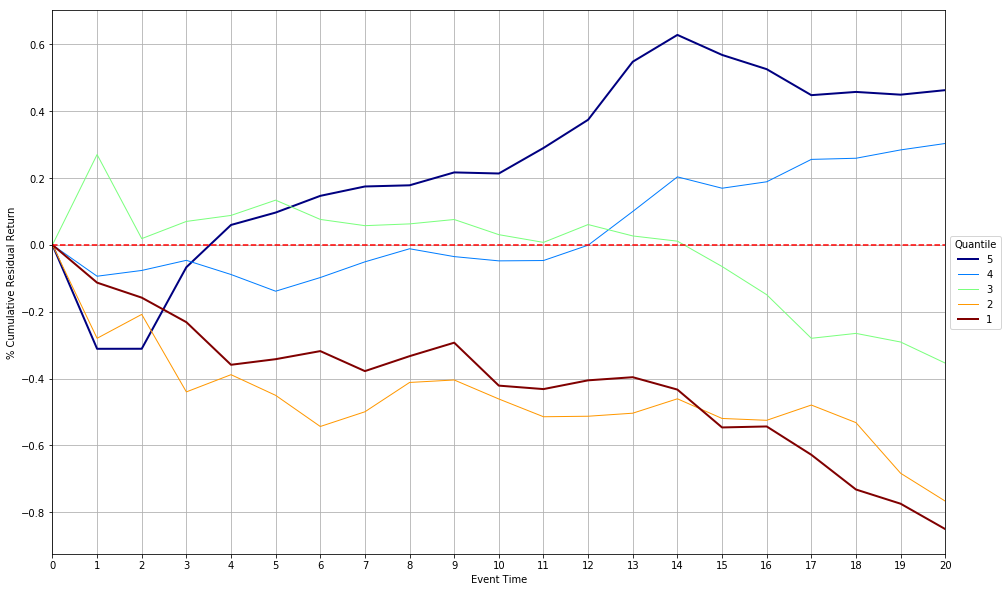

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.11%,-0.16%,-0.23%,-0.36%,-0.34%,-0.42%,-0.55%,-0.85%
2.0,-0.28%,-0.21%,-0.44%,-0.39%,-0.45%,-0.46%,-0.52%,-0.77%
3.0,0.27%,0.02%,0.07%,0.09%,0.13%,0.03%,-0.06%,-0.35%
4.0,-0.09%,-0.08%,-0.05%,-0.09%,-0.14%,-0.05%,0.17%,0.30%
5.0,-0.31%,-0.31%,-0.07%,0.06%,0.10%,0.21%,0.57%,0.46%


In [17]:
display_results(es2014, 'All Stocks (2014)')

In [18]:
# Run 2013 event study

start_date = '2013-01-01'
end_date = '2014-01-01'

es2013 = run_event_study(start_date, end_date)

### All Stocks (2013)

Num Events: 2,025


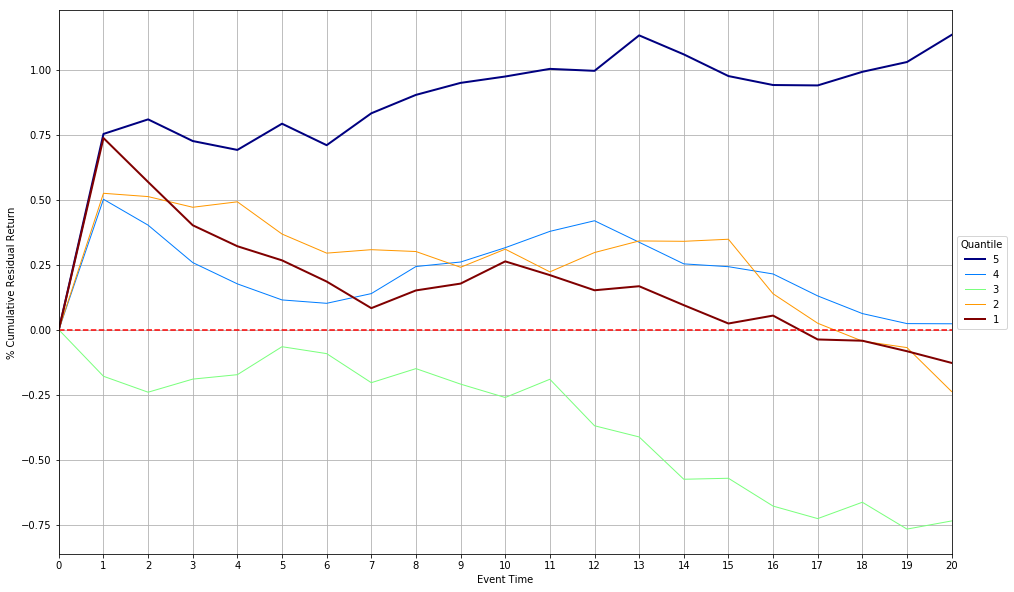

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,0.74%,0.57%,0.40%,0.32%,0.27%,0.26%,0.02%,-0.13%
2.0,0.52%,0.51%,0.47%,0.49%,0.37%,0.31%,0.35%,-0.24%
3.0,-0.18%,-0.24%,-0.19%,-0.17%,-0.07%,-0.26%,-0.57%,-0.74%
4.0,0.50%,0.40%,0.26%,0.18%,0.11%,0.32%,0.24%,0.02%
5.0,0.75%,0.81%,0.73%,0.69%,0.79%,0.97%,0.98%,1.13%


In [19]:
display_results(es2013, 'All Stocks (2013)')

In [20]:
# Run 2012 event study

start_date = '2012-01-01'
end_date = '2013-01-01'

es2012 = run_event_study(start_date, end_date)

### All Stocks (2012)

Num Events: 988


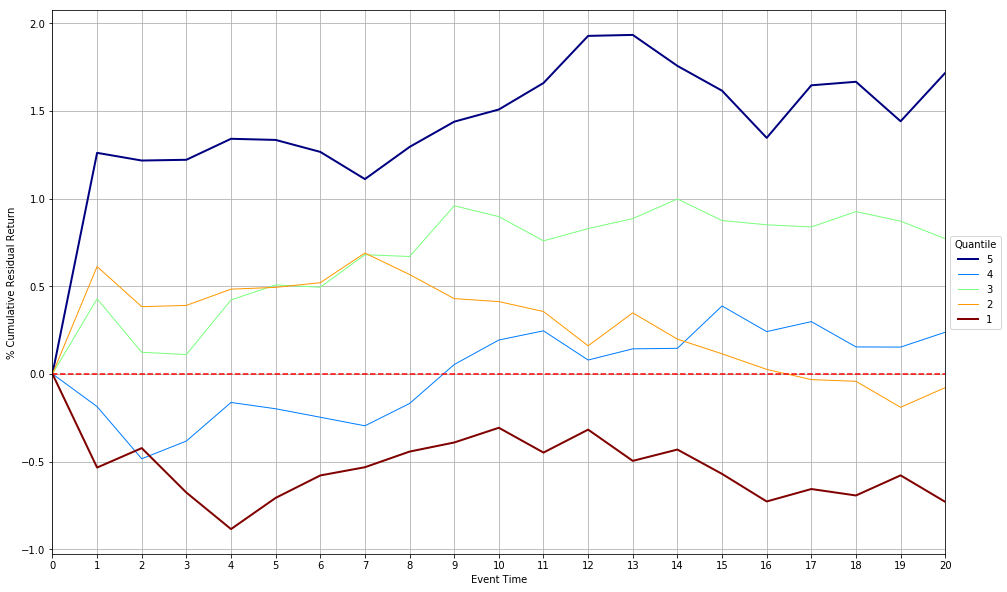

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1.0,-0.53%,-0.42%,-0.68%,-0.89%,-0.71%,-0.31%,-0.57%,-0.73%
2.0,0.61%,0.38%,0.39%,0.48%,0.49%,0.41%,0.11%,-0.08%
3.0,0.43%,0.12%,0.11%,0.42%,0.51%,0.90%,0.87%,0.77%
4.0,-0.19%,-0.48%,-0.38%,-0.16%,-0.20%,0.19%,0.39%,0.24%
5.0,1.26%,1.22%,1.22%,1.34%,1.33%,1.51%,1.62%,1.72%


In [21]:
display_results(es2012, 'All Stocks (2012)')

## Sector Analysis

In [23]:
es_sectors = run_event_study(cfg.DEFAULT_START_DATE, cfg.DEFAULT_END_DATE, join_fn=join_sectors)


### Consumer Discretionary (All-Time)

Num Events: 4,950


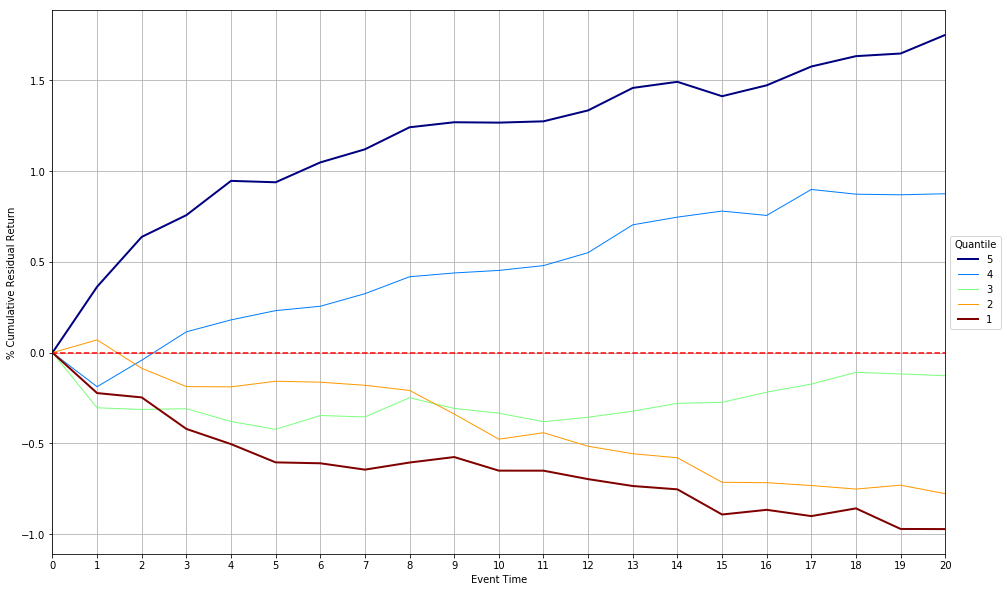

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.22%,-0.25%,-0.42%,-0.50%,-0.60%,-0.65%,-0.89%,-0.97%
2,0.07%,-0.09%,-0.19%,-0.19%,-0.16%,-0.48%,-0.71%,-0.78%
3,-0.30%,-0.31%,-0.31%,-0.38%,-0.42%,-0.33%,-0.27%,-0.13%
4,-0.19%,-0.04%,0.11%,0.18%,0.23%,0.45%,0.78%,0.88%
5,0.36%,0.64%,0.76%,0.95%,0.94%,1.27%,1.41%,1.75%


### Consumer Staples (All-Time)

Num Events: 1,373


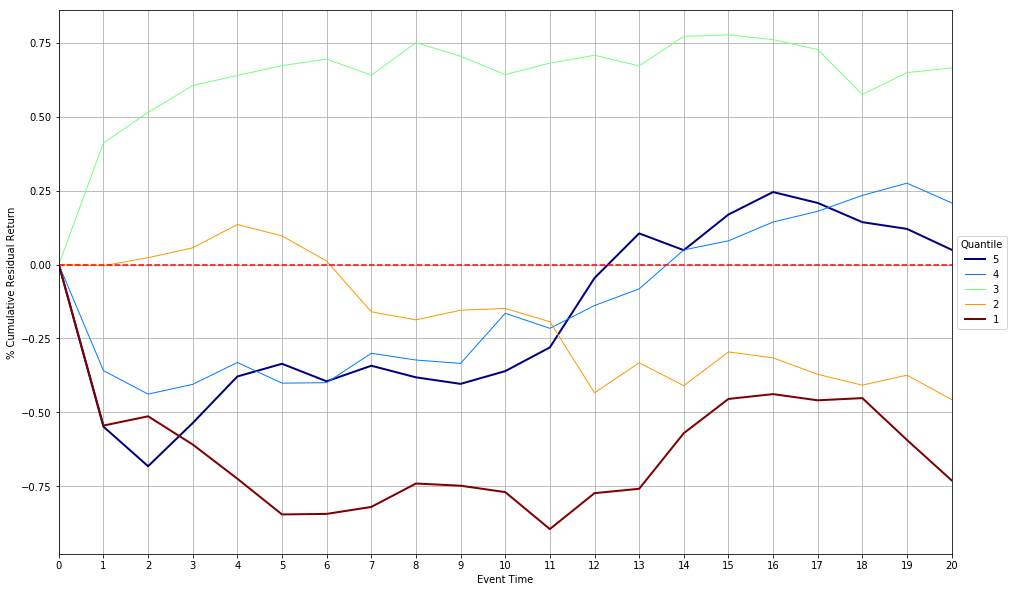

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.54%,-0.51%,-0.61%,-0.72%,-0.85%,-0.77%,-0.45%,-0.73%
2,-0.00%,0.02%,0.06%,0.14%,0.10%,-0.15%,-0.30%,-0.46%
3,0.41%,0.51%,0.61%,0.64%,0.67%,0.64%,0.78%,0.66%
4,-0.36%,-0.44%,-0.41%,-0.33%,-0.40%,-0.16%,0.08%,0.21%
5,-0.55%,-0.68%,-0.54%,-0.38%,-0.34%,-0.36%,0.17%,0.05%


### Energy (All-Time)

Num Events: 1,343


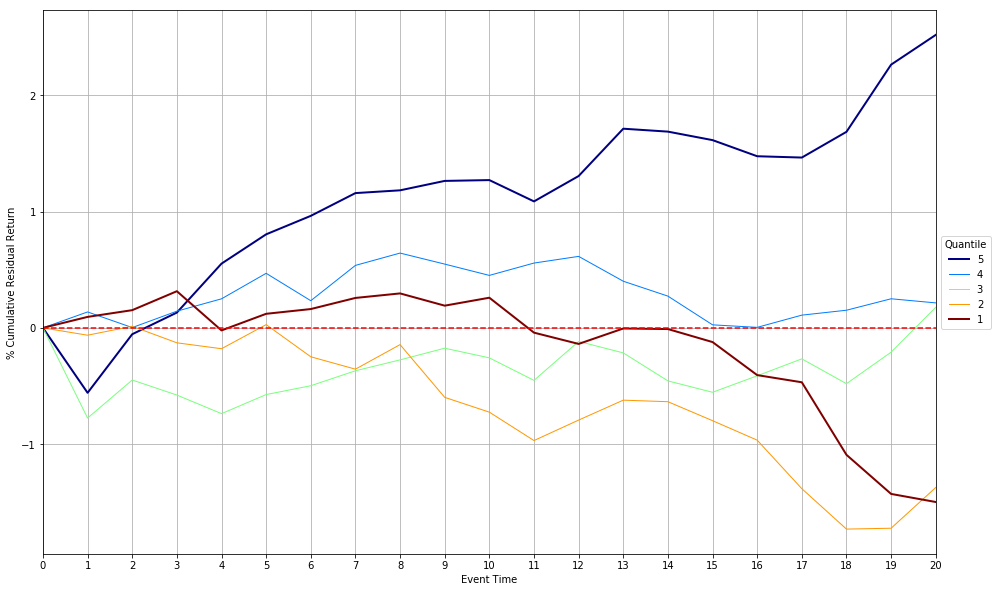

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.09%,0.15%,0.32%,-0.02%,0.12%,0.26%,-0.12%,-1.50%
2,-0.06%,0.01%,-0.13%,-0.18%,0.03%,-0.72%,-0.80%,-1.37%
3,-0.77%,-0.45%,-0.58%,-0.74%,-0.57%,-0.26%,-0.55%,0.18%
4,0.14%,0.00%,0.14%,0.25%,0.47%,0.45%,0.03%,0.21%
5,-0.56%,-0.05%,0.13%,0.55%,0.80%,1.27%,1.61%,2.52%


### Financials (All-Time)

Num Events: 1,601


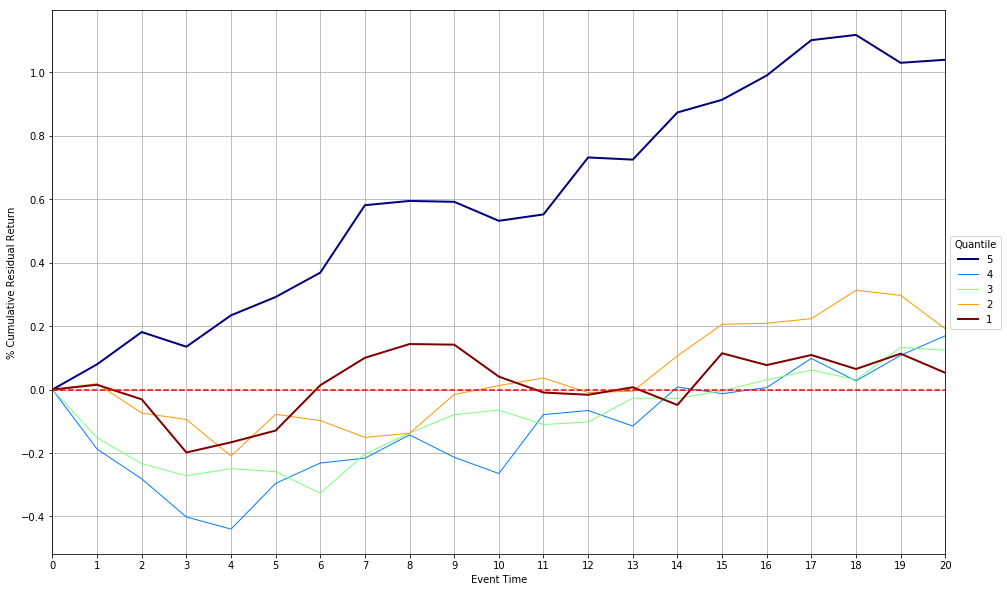

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.02%,-0.03%,-0.20%,-0.17%,-0.13%,0.04%,0.11%,0.05%
2,0.02%,-0.07%,-0.09%,-0.21%,-0.08%,0.01%,0.21%,0.19%
3,-0.15%,-0.23%,-0.27%,-0.25%,-0.26%,-0.06%,-0.00%,0.12%
4,-0.19%,-0.28%,-0.40%,-0.44%,-0.30%,-0.26%,-0.01%,0.17%
5,0.08%,0.18%,0.14%,0.23%,0.29%,0.53%,0.91%,1.04%


### Health Care (All-Time)

Num Events: 3,122


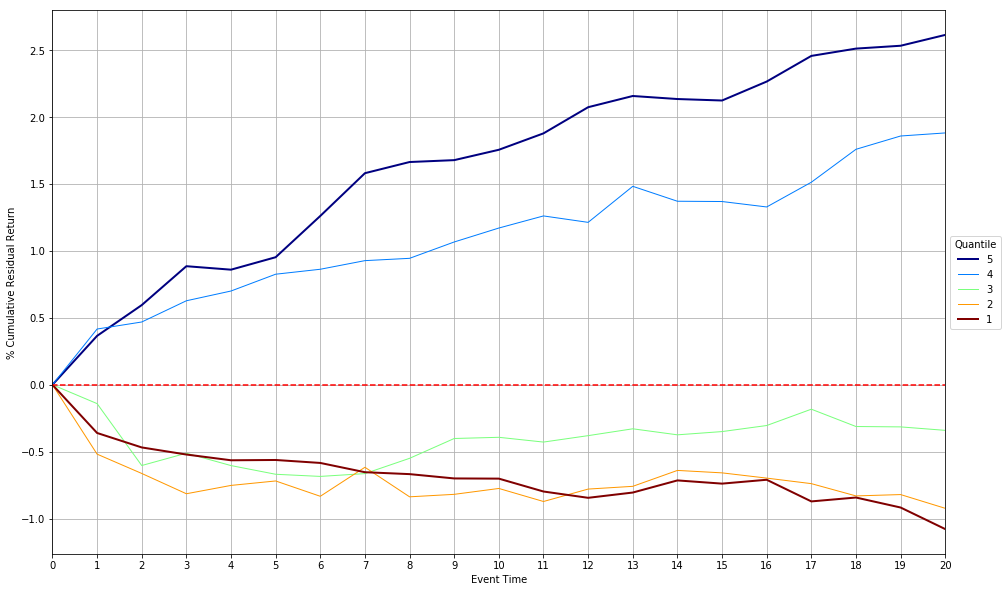

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.36%,-0.47%,-0.52%,-0.56%,-0.56%,-0.70%,-0.74%,-1.08%
2,-0.52%,-0.66%,-0.81%,-0.75%,-0.72%,-0.77%,-0.66%,-0.92%
3,-0.14%,-0.60%,-0.51%,-0.60%,-0.67%,-0.39%,-0.35%,-0.34%
4,0.42%,0.47%,0.63%,0.70%,0.83%,1.17%,1.37%,1.88%
5,0.37%,0.60%,0.89%,0.86%,0.95%,1.76%,2.12%,2.61%


### Industrials (All-Time)

Num Events: 4,151


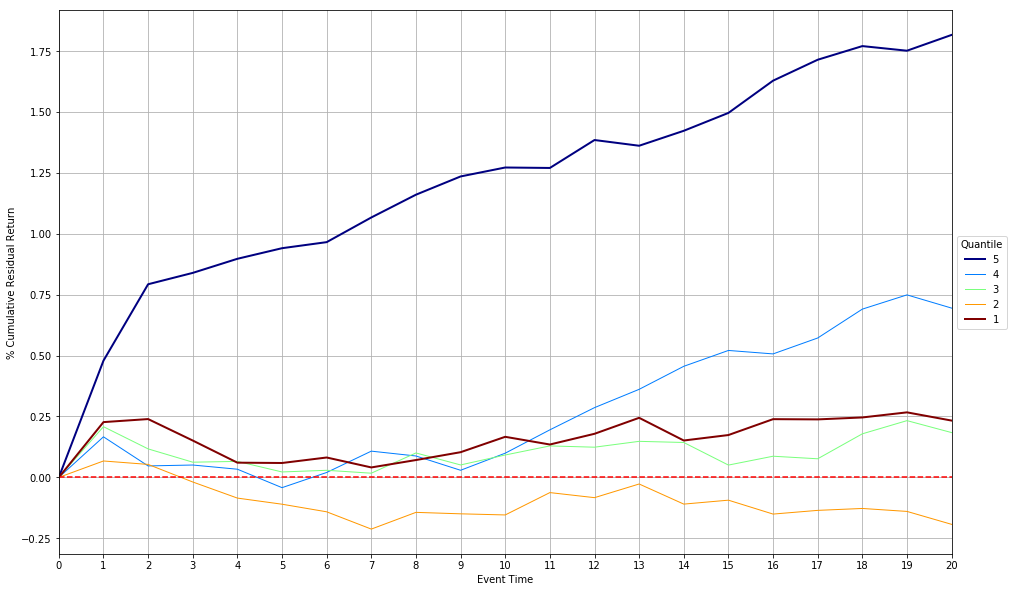

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.23%,0.24%,0.15%,0.06%,0.06%,0.17%,0.17%,0.23%
2,0.07%,0.05%,-0.02%,-0.08%,-0.11%,-0.15%,-0.09%,-0.19%
3,0.21%,0.12%,0.06%,0.07%,0.02%,0.09%,0.05%,0.18%
4,0.17%,0.05%,0.05%,0.03%,-0.04%,0.10%,0.52%,0.69%
5,0.48%,0.79%,0.84%,0.90%,0.94%,1.27%,1.50%,1.82%


### Information Technology (All-Time)

Num Events: 5,465


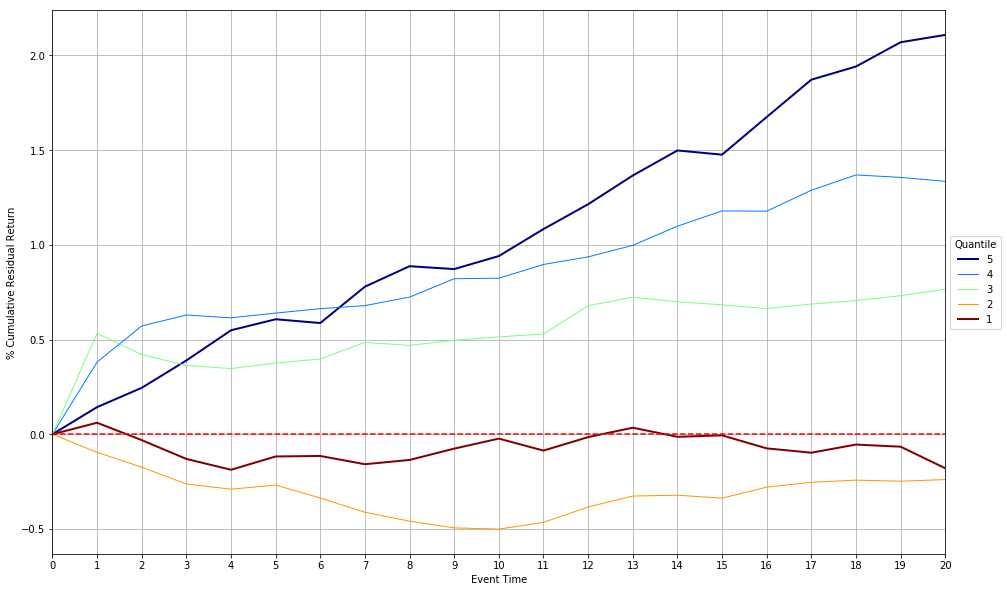

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.06%,-0.03%,-0.13%,-0.19%,-0.12%,-0.02%,-0.01%,-0.18%
2,-0.10%,-0.17%,-0.26%,-0.29%,-0.27%,-0.50%,-0.34%,-0.24%
3,0.53%,0.42%,0.36%,0.35%,0.38%,0.51%,0.68%,0.77%
4,0.38%,0.57%,0.63%,0.61%,0.64%,0.82%,1.18%,1.34%
5,0.14%,0.25%,0.39%,0.55%,0.61%,0.94%,1.48%,2.11%


### Materials (All-Time)

Num Events: 1,414


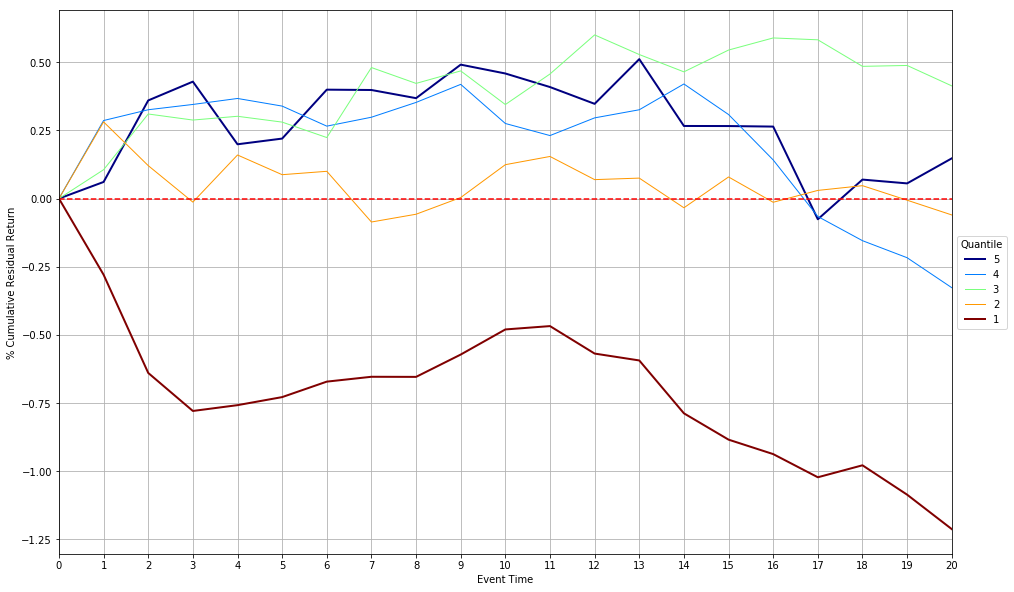

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.28%,-0.64%,-0.78%,-0.76%,-0.73%,-0.48%,-0.88%,-1.21%
2,0.28%,0.12%,-0.01%,0.16%,0.09%,0.12%,0.08%,-0.06%
3,0.11%,0.31%,0.29%,0.30%,0.28%,0.34%,0.54%,0.41%
4,0.29%,0.33%,0.35%,0.37%,0.34%,0.28%,0.31%,-0.33%
5,0.06%,0.36%,0.43%,0.20%,0.22%,0.46%,0.27%,0.15%


### Telecommunication Services (All-Time)

Num Events: 280


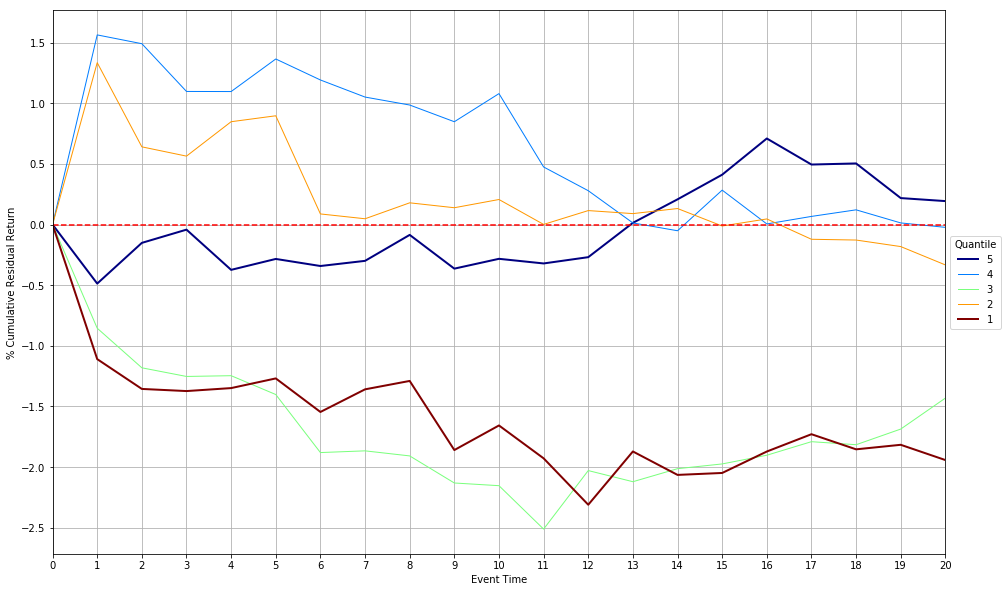

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-1.11%,-1.36%,-1.37%,-1.35%,-1.27%,-1.66%,-2.05%,-1.94%
2,1.34%,0.64%,0.56%,0.85%,0.90%,0.21%,-0.01%,-0.33%
3,-0.85%,-1.18%,-1.25%,-1.25%,-1.40%,-2.15%,-1.97%,-1.43%
4,1.56%,1.49%,1.10%,1.10%,1.37%,1.08%,0.28%,-0.02%
5,-0.49%,-0.15%,-0.04%,-0.37%,-0.28%,-0.28%,0.41%,0.19%


### Utilities (All-Time)

Num Events: 628


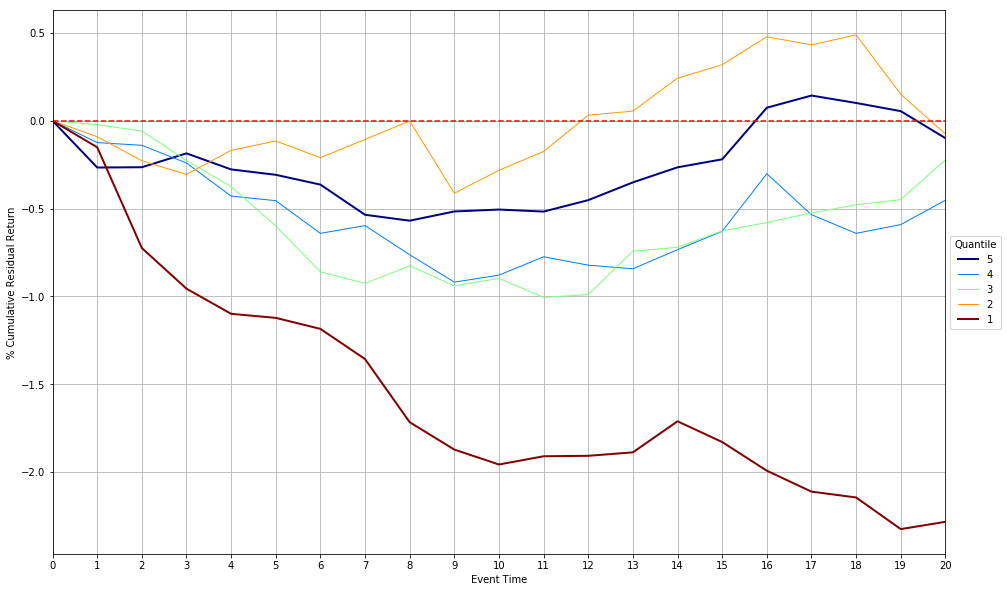

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.15%,-0.72%,-0.96%,-1.10%,-1.12%,-1.96%,-1.83%,-2.28%
2,-0.09%,-0.23%,-0.31%,-0.17%,-0.12%,-0.28%,0.32%,-0.08%
3,-0.02%,-0.06%,-0.23%,-0.38%,-0.60%,-0.90%,-0.63%,-0.22%
4,-0.12%,-0.14%,-0.24%,-0.43%,-0.45%,-0.88%,-0.63%,-0.45%
5,-0.27%,-0.26%,-0.19%,-0.28%,-0.31%,-0.51%,-0.22%,-0.10%


In [24]:
sectors = dfutils.column_values(es_sectors[0], 'sector').unique().tolist()

for sector in sectors:
    sdf = es_sectors[0]
    sdf = filter(sdf, 'sector', sector)
    display_results((sdf, None), '{} (All-Time)'.format(sector))


## Market Cap Analysis

In [25]:
es_market_caps = run_event_study(cfg.DEFAULT_START_DATE, cfg.DEFAULT_END_DATE, join_fn=join_market_caps)


### Micro Cap (All-Time)

Num Events: 394


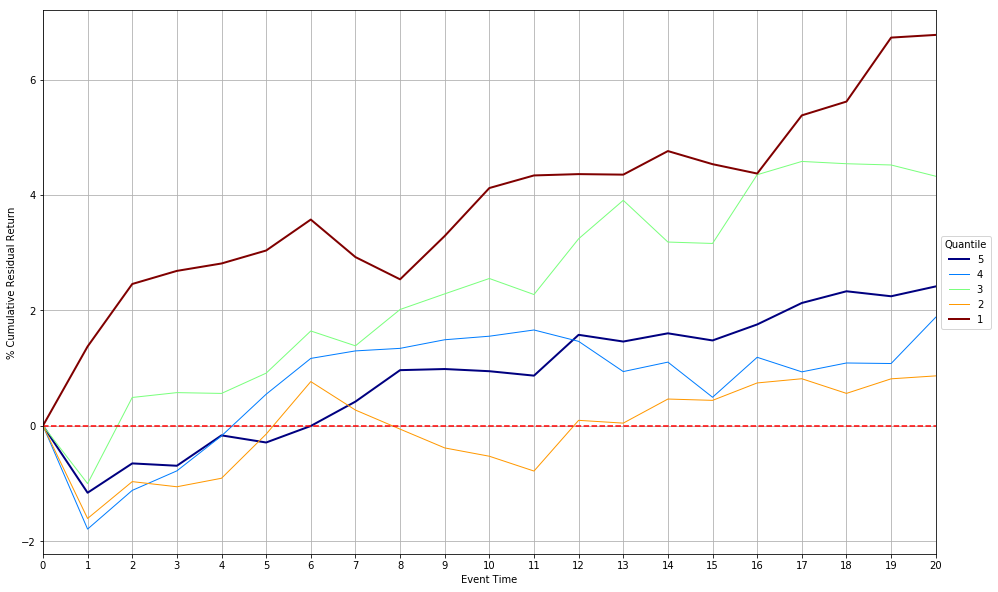

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,1.37%,2.46%,2.68%,2.81%,3.04%,4.12%,4.53%,6.77%
2,-1.61%,-0.97%,-1.06%,-0.91%,-0.15%,-0.53%,0.44%,0.86%
3,-1.00%,0.49%,0.57%,0.56%,0.91%,2.55%,3.16%,4.32%
4,-1.79%,-1.12%,-0.78%,-0.18%,0.55%,1.55%,0.49%,1.88%
5,-1.16%,-0.65%,-0.69%,-0.17%,-0.29%,0.94%,1.48%,2.41%


### Small Cap (All-Time)

Num Events: 7,554


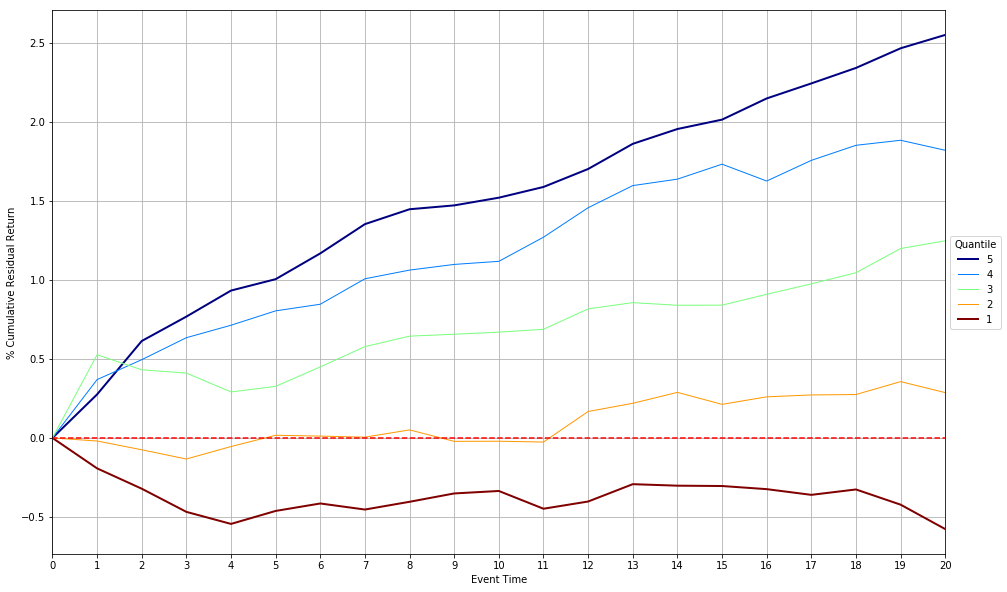

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.19%,-0.32%,-0.47%,-0.54%,-0.46%,-0.34%,-0.30%,-0.58%
2,-0.02%,-0.07%,-0.13%,-0.05%,0.02%,-0.02%,0.21%,0.29%
3,0.53%,0.43%,0.41%,0.29%,0.33%,0.67%,0.84%,1.25%
4,0.37%,0.50%,0.63%,0.71%,0.80%,1.12%,1.73%,1.82%
5,0.28%,0.61%,0.77%,0.93%,1.00%,1.52%,2.01%,2.55%


### Mid Cap (All-Time)

Num Events: 8,984


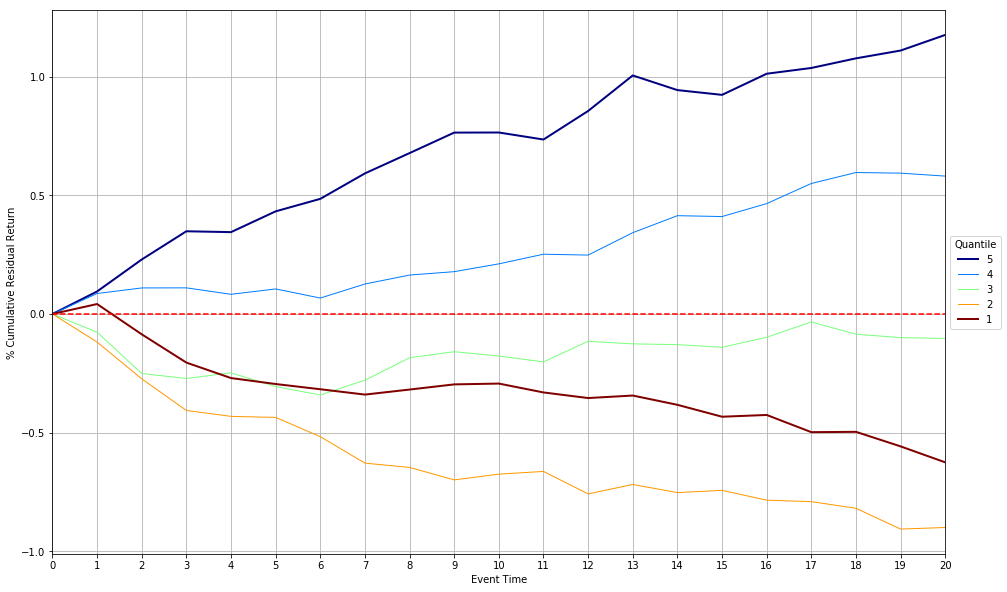

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,0.04%,-0.09%,-0.21%,-0.27%,-0.30%,-0.29%,-0.43%,-0.63%
2,-0.12%,-0.27%,-0.41%,-0.43%,-0.44%,-0.68%,-0.74%,-0.90%
3,-0.08%,-0.25%,-0.27%,-0.25%,-0.31%,-0.18%,-0.14%,-0.10%
4,0.09%,0.11%,0.11%,0.08%,0.11%,0.21%,0.41%,0.58%
5,0.10%,0.23%,0.35%,0.35%,0.43%,0.77%,0.92%,1.18%


### Large Cap (All-Time)

Num Events: 6,881


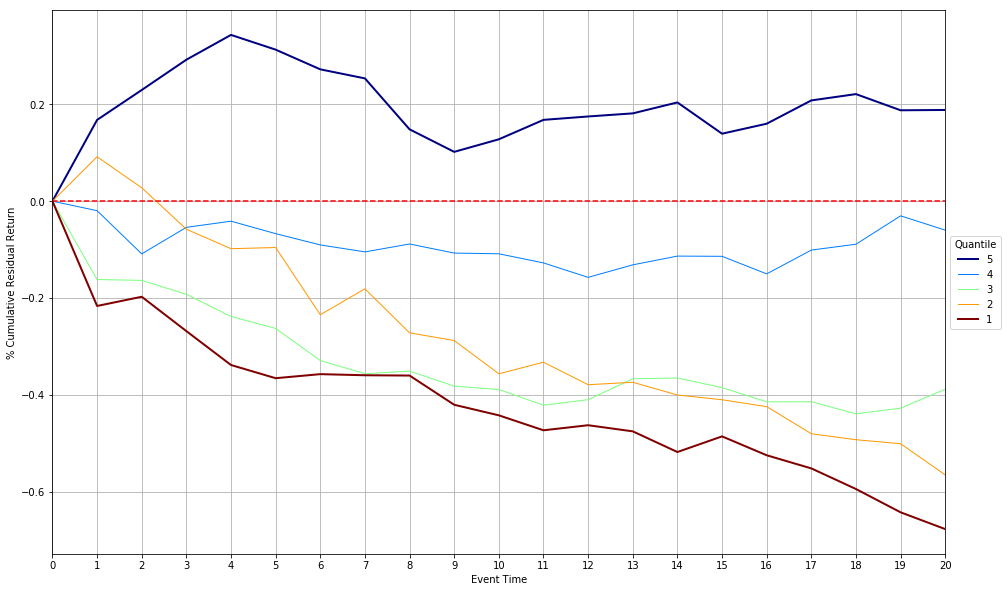

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.22%,-0.20%,-0.27%,-0.34%,-0.37%,-0.44%,-0.49%,-0.68%
2,0.09%,0.03%,-0.06%,-0.10%,-0.10%,-0.36%,-0.41%,-0.57%
3,-0.16%,-0.16%,-0.19%,-0.24%,-0.26%,-0.39%,-0.39%,-0.39%
4,-0.02%,-0.11%,-0.05%,-0.04%,-0.07%,-0.11%,-0.11%,-0.06%
5,0.17%,0.23%,0.29%,0.34%,0.31%,0.13%,0.14%,0.19%


### Mega Cap (All-Time)

Num Events: 286


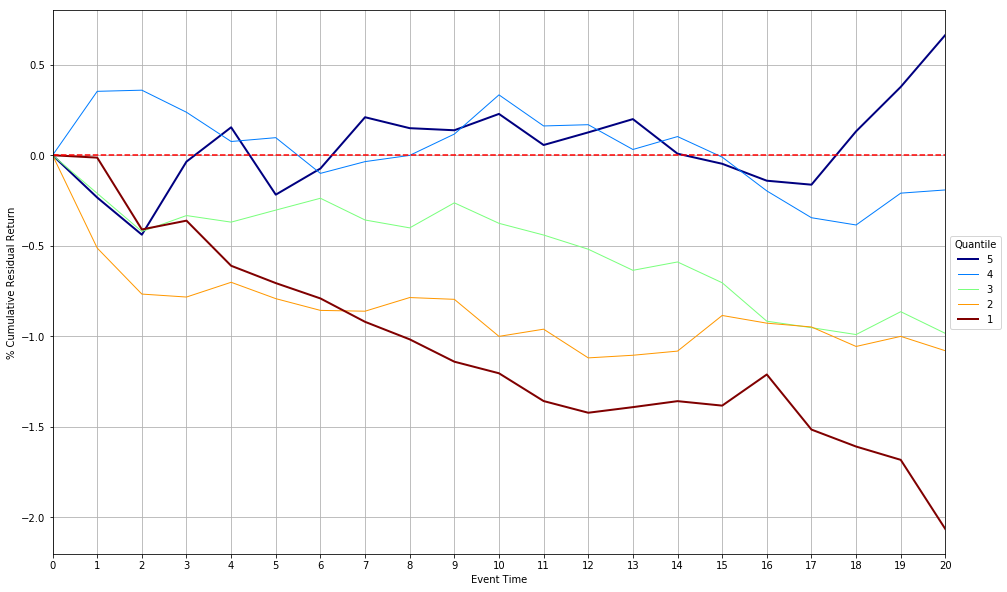

event_time,1,2,3,4,5,10,15,20
quantile,,,,,,,,
1,-0.01%,-0.41%,-0.36%,-0.61%,-0.71%,-1.20%,-1.38%,-2.07%
2,-0.51%,-0.77%,-0.78%,-0.70%,-0.79%,-1.00%,-0.89%,-1.08%
3,-0.21%,-0.42%,-0.33%,-0.37%,-0.30%,-0.38%,-0.70%,-0.98%
4,0.35%,0.36%,0.24%,0.08%,0.10%,0.33%,-0.01%,-0.19%
5,-0.23%,-0.44%,-0.04%,0.15%,-0.22%,0.23%,-0.05%,0.67%


In [26]:
market_cap_types = ['Micro', 'Small', 'Mid', 'Large', 'Mega']

for market_cap_type in market_cap_types:
    mdf = es_market_caps[0]
    mdf = filter(mdf, 'market_cap_type', market_cap_type)
    display_results((mdf, None), '{} Cap (All-Time)'.format(market_cap_type))
